# Project 1: Navigation

The following code initialized the Unity environment. If a new agent is trained please restart the kernel.

In [1]:
import torch
from unityagents import UnityEnvironment

# create environment

env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe', seed=0) # change path of environment if needed
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Trainig

The following code can be used to train the agent. You can change the configuration of the agent as well as which agent and network should be used in the [config.json](config.json) file. This is a list of the configurations:
- **name**: The name of the approach used for saving and loading the agent and its statistics
- **agent**: The name of the agent to use
- **num_episode**: The number of episodes used during training
- **agents**: The configurations for the different agent available

Episode 100	Average Loss: -0.38996	Average Score: 0.00870
Episode 200	Average Loss: -0.34364	Average Score: 0.00100
Episode 300	Average Loss: -0.21502	Average Score: 0.05520
Episode 400	Average Loss: -0.17417	Average Score: 0.03040
Episode 500	Average Loss: -0.13851	Average Score: 0.02730
Episode 600	Average Loss: -0.09841	Average Score: 0.04160
Episode 700	Average Loss: -0.07496	Average Score: 0.04110
Episode 800	Average Loss: -0.06579	Average Score: 0.03800
Episode 900	Average Loss: -0.06321	Average Score: 0.03990
Episode 1000	Average Loss: -0.06210	Average Score: 0.04290
Episode 1100	Average Loss: -0.06270	Average Score: 0.02650
Episode 1200	Average Loss: -0.06037	Average Score: 0.03280
Episode 1300	Average Loss: -0.05835	Average Score: 0.06880
Episode 1400	Average Loss: -0.05748	Average Score: 0.05890
Episode 1500	Average Loss: -0.06011	Average Score: 0.10800
Episode 1600	Average Loss: -0.07182	Average Score: 0.21140
Episode 1700	Average Loss: -0.10722	Average Score: 0.27710
Episod

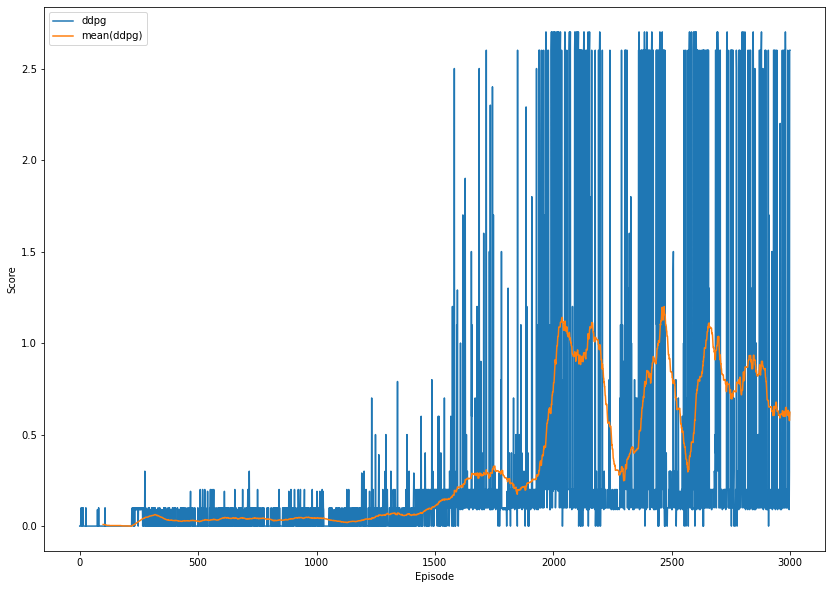

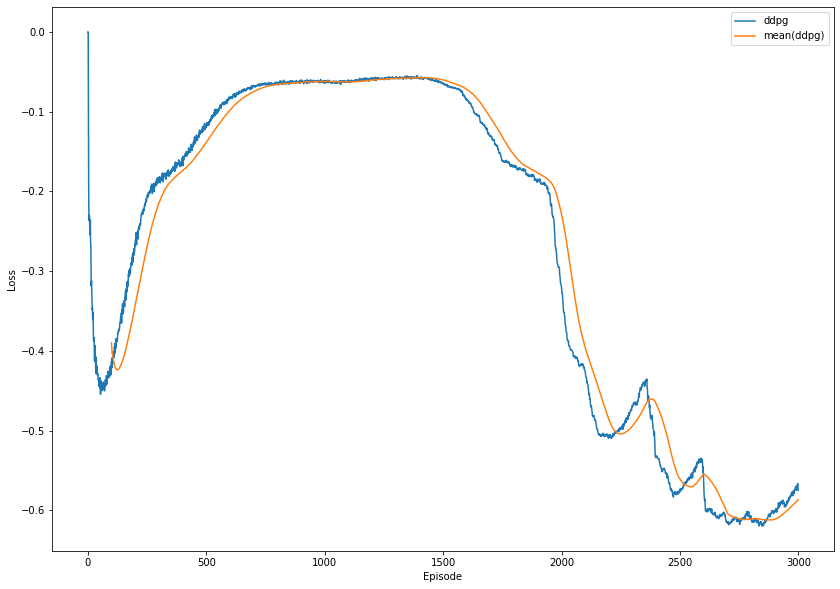

In [14]:
import numpy as np
import json
import os

from importlib import reload
import agents.agents
reload(agents.agents)
from agents.agents import get_agent
import utils.visualizations
reload(utils.visualizations)
import utils.visualizations as vis


# load current config
with open("config.json", "r") as f:
    config = json.load(f)

# create results folder
if not os.path.exists("./data"):
    os.mkdir("./data")
if not os.path.exists(f"./data/{config['name']}"):
    os.mkdir(f"./data/{config['name']}")

# copy current config to result folder
with open(f"./data/{config['name']}/config.json", "w") as f2:
    json.dump(config, f2)

# get env infos
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

# create agent
agent = get_agent(config["agent"], config["agents"], state_size, action_size, 0)

# trains the agent and collect statistics
scores = []
losses = []
for i_episode in range(1, config["num_episodes"]+1):
    score = np.zeros((2,))

    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations

    # one episode
    while True:
        # select action
        action = agent.act(state)

        # get feddback from environment
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        loss = agent.step(state, action, reward, next_state, done)
        if loss is not None:
            losses.append(np.mean(loss))

        state = next_state
        score += reward
        if np.any(done):
            # episode ended
            break

    #statistics
    scores.append(np.max(score))
    if i_episode < 100:
        print('\rEpisode {}\tAverage Loss: {:.5f}\tAverage Score: {:.5f}'.format(i_episode, np.mean(losses), np.mean(scores)), end="")
    else:
        print('\rEpisode {}\tAverage Loss: {:.5f}\tAverage Score: {:.5f}'.format(i_episode, np.mean(losses[-100:]), np.mean(scores[-100:])), end="")
    if i_episode % 100 == 0:
        if i_episode < 100:
            print('\rEpisode {}\tAverage Loss: {:.5f}\tAverage Score: {:.5f}'.format(i_episode, np.mean(losses), np.mean(scores)))
        else:
            print('\rEpisode {}\tAverage Loss: {:.5f}\tAverage Score: {:.5f}'.format(i_episode, np.mean(losses[-100:]), np.mean(scores[-100:])))

# save agent and statistics
agent.save(config["name"])
np.savez(f"./data/{config['name']}/statistics.npz", scores=scores, losses=losses)

# plot statistics
for show in [False, True]:
    vis.plot_learning_curve([scores], [config["name"]], show=show)
    vis.plot_learning_curve2([losses], [config["name"]], show=show)


## Test

The following code can be used to test the saved agent for one episode. You can change which agent to test in the [config.json](config.json) file.

In [16]:
import json

from importlib import reload
import agents.agents
reload(agents.agents)
from agents.agents import get_agent
import utils.visualizations
reload(utils.visualizations)
import utils.visualizations as vis

# load current config
with open("config.json", "r") as f:
    config = json.load(f)
with open(f"./data/{config['name']}/config.json", "r") as f:
    config = json.load(f)

# get env infos
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

# create agent and load trained parameters
agent = get_agent(config["agent"], config["agents"], state_size, action_size, 0)
agent.load(config["name"])

# one episode test
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
score = np.zeros((2,))
while True:
    action = agent.act(state, test=True)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done = env_info.local_done
    score += reward
    state = next_state
    if np.any(done):
        break

# statistics
print("Score: {:.3f}, {:.3f}".format(score[0], score[1]))

Score: 2.600, 2.600


If you don't need the environment anymore, you can close it.

In [17]:
env.close()